## 使用 CNN 实现手写数据集的识别

In [1]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision # torch 里面自带的数据库
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
# Hyper Parameters
EPOCH = 1
BATCH_SIZE = 50
LR = 0.001
DOWNLOAD_MNIST = False # 如果下载了就设为 false，没下载就设为 true

In [3]:
# 下载 mnist 手写数据集
train_data = torchvision.datasets.MNIST(
    root="./mnist", # 保存路径
    train=True,
    transform=torchvision.transforms.ToTensor(), # 原始是 numpy 的数据，将numpy 转为 tensor
    download=DOWNLOAD_MNIST # 是否下载 mnist
)

c:\users\wuzhengdong\appdata\local\continuum\anaconda3\envs\wz\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\users\wuzhengdong\appdata\local\continuum\anaconda3\envs\wz\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


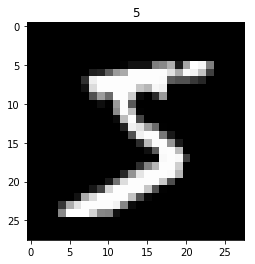

In [4]:
# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

### batch training

In [5]:
train_loader = Data.DataLoader(
    dataset=train_data, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

In [6]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]

c:\users\wuzhengdong\appdata\local\continuum\anaconda3\envs\wz\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\users\wuzhengdong\appdata\local\continuum\anaconda3\envs\wz\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### create cnn network

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [8]:
cnn = CNN()
cnn

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

### training

In [9]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

### 输入的类型需要注意！ x.dtype = float32, y.dtype=int64

In [10]:
for step, (x, y) in enumerate(train_loader):
    print(x.dtype)
    print(y.dtype)
    print(x.size())
    print(y.size())
    batch_x = Variable(x)
    batch_y = Variable(y)
    break

torch.float32
torch.int64
torch.Size([50, 1, 28, 28])
torch.Size([50])


### 画图的功能了解即可

0.089


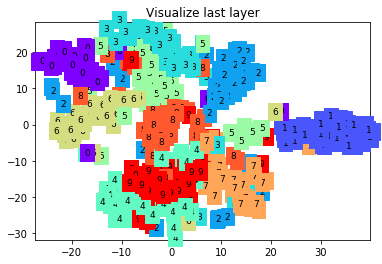

0.899


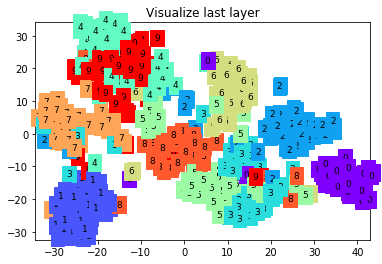

0.9385


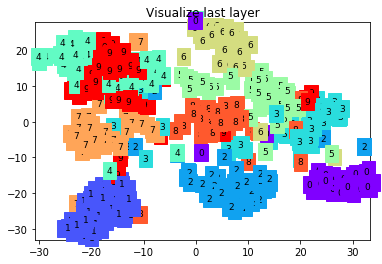

0.945


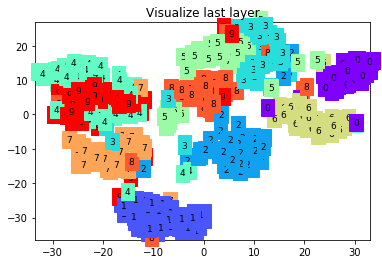

0.96


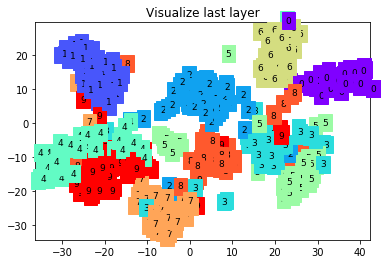

0.9645


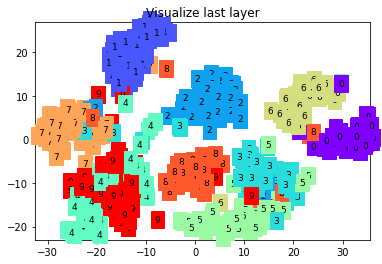

0.962


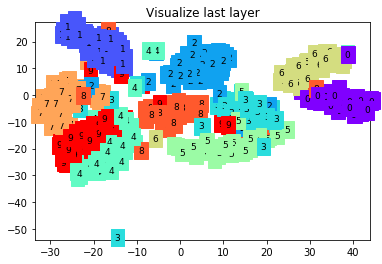

0.9705


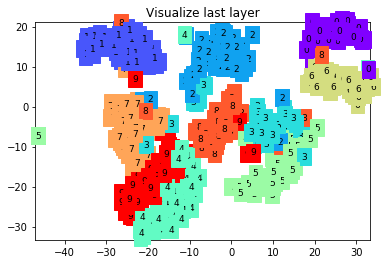

0.969


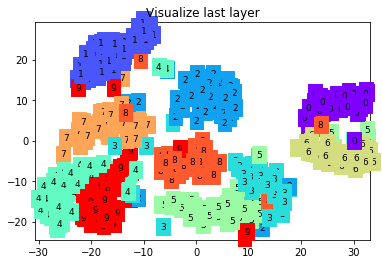

0.971


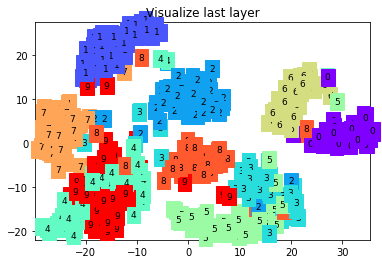

0.974


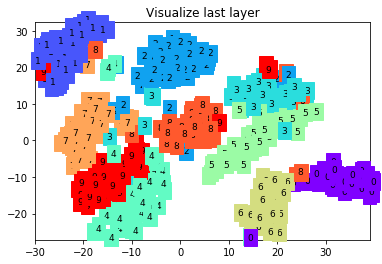

0.9785


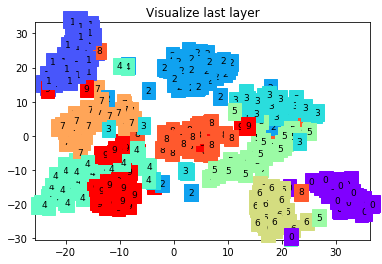

In [11]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print(accuracy)
            #print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0], '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

### 使用测试集测试

In [12]:
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y)
print(test_y[:10].numpy())

[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]


In [13]:
torch.max(test_output,1)

(tensor([13.1383,  9.4139,  4.8070, 10.4790,  9.1620,  5.7337,  5.0791,  5.1449,
          7.3340,  5.9231], grad_fn=<MaxBackward0>),
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]))

In [14]:
test_output

tensor([[ -3.8320,  -7.5849,  -2.6823,   2.0655, -12.5845,  -3.5983, -19.2946,
          13.1383,  -5.4896,  -0.9294],
        [  0.3896,   2.1197,   9.4139,  -1.9793, -11.8201,  -7.9425,  -2.4301,
         -14.6008,  -0.6529, -15.7148],
        [ -3.6918,   4.8070,  -3.2948,  -3.3210,   0.7374,  -5.4508,  -2.8098,
          -0.4786,  -0.9990,  -2.9653],
        [ 10.4790, -15.7509,  -4.7410,  -7.9345,  -5.6104,  -4.2476,  -0.3531,
          -4.4238,  -3.9152,  -2.1358],
        [ -5.3023,  -6.2714,  -7.3214,  -7.1497,   9.1620,  -7.9954,  -5.0611,
          -0.6740,  -2.8979,   2.5597],
        [ -4.4118,   5.7337,  -4.4106,  -3.7702,   1.1734,  -7.6367,  -4.5815,
           0.5235,  -0.8999,  -2.6781],
        [-11.5195,  -5.2166,  -7.7842,  -6.8025,   5.0791,  -3.4385,  -7.7082,
          -0.3614,   1.8069,   0.4022],
        [ -9.5128,  -5.2406,  -3.6035,  -2.4840,   0.7661,  -0.5348,  -7.5080,
          -5.0665,   1.4690,   5.1449],
        [ -6.0276, -20.5295, -11.8431,  -9.4007,